# Convolutional NN

In [1]:
import numpy as np
import gzip
import os
import pickle
from matplotlib import pyplot


from si.data import Dataset
from si.util import to_categorical

Load the MNIST dataset

In [2]:
def load_mnist(sample_size=None):
    DIR = os.path.dirname(os.path.realpath('.'))
    filename = os.path.join(DIR, 'datasets/mnist.pkl.gz')
    f = gzip.open(filename, 'rb')
    data = pickle.load(f, encoding='bytes')
    (x_train, y_train), (x_test, y_test) = data
    if sample_size:
        return Dataset(x_train[:sample_size],y_train[:sample_size]),Dataset(x_test,y_test)
    else:
        return Dataset(x_train,y_train),Dataset(x_test,y_test)

In [3]:
train,test = load_mnist(500)

In [4]:
def preprocess(train):
    # reshape and normalize input data 
    train.X = train.X.reshape(train.X.shape[0], 28, 28, 1)
    train.X = train.X.astype('float32')
    train.X /= 255
    train.y = to_categorical(train.y)

In [5]:
preprocess(train)
preprocess(test)

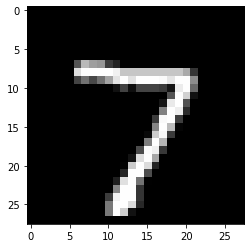

In [6]:
def plot_img(img,shape=(28,28)):
    pic = (img*255).reshape(shape)
    pic = pic.astype('int')
    pyplot.imshow(pic, cmap=pyplot.get_cmap('gray'))
    pyplot.show()

plot_img(test.X[0])

In [16]:
from si.supervised import NN, Dense, Activation, Conv2D, Flatten, MaxPooling2D
from si.util import Tanh, Sigmoid, cross_entropy, cross_entropy_prime

### Check Conv2D

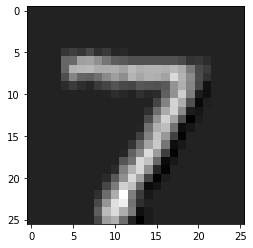

In [8]:
conv = Conv2D((28, 28,1), (3, 3), 1)
out = conv.forward(test.X[:1])
plot_img(out, shape=(26, 26))


### Check MaxPooling

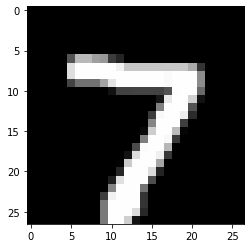

In [9]:
pool = MaxPooling2D(size=2,stride=1)
out = pool.forward(test.X[:1])
plot_img(out, shape=(27, 27))


Build the model

In [21]:
net = NN(epochs=2000,lr=0.1,verbose=False)
net.add(Conv2D((28, 28,1), (3, 3), 1))  
net.add(Activation(Tanh()))
net.add(MaxPooling2D())
net.add(Flatten())
net.add(Dense(25*25*1, 100))           
net.add(Activation(Tanh()))
net.add(Dense(100, 10))                
net.add(Activation(Sigmoid()))

net.useLoss(cross_entropy, cross_entropy_prime)

Train the model

In [22]:
net.fit(train)

In [12]:
out = net.predict(test.X[0:3])
print("\n")
print("predicted values : ")
print(np.round(out), end="\n")
print("true values : ")
print(test.y[0:3])



predicted values : 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
true values : 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
conv1 = net.layers[0]
act1 = net.layers[1]
pool1 = net.layers[2]

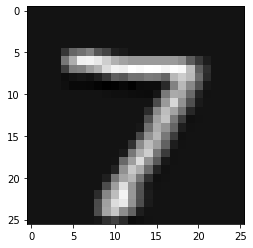

In [14]:
img1 = conv1.forward(test.X[:1])
plot_img(img1,shape=(26,26))


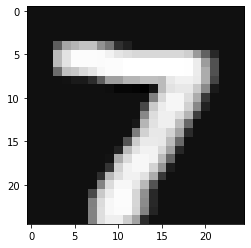

In [15]:
img2= pool1.forward(act1.forward(img1))
plot_img(img2,shape=(25,25))